# Semantic Segmentation

## Initial setup:

+ Imports
+ Download data
+ Download model 

In [7]:
# Standard imports
import os
import pickle
import sys
import time
from glob import glob
from math import ceil
from urllib import request
from zipfile import ZipFile

# Third-party imports
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
import tensorflow as tf

# Install tqdm
!pip install tqdm
from tqdm import tqdm

print('Python', sys.version)
print('Numpy', np.__version__)
print('Tensorflow', tf.__version__)

# Matplotlib configuration
%matplotlib inline

A4_PORTRAIT = (8.27, 11.69)
A4_LANDSCAPE = A4_PORTRAIT[::-1]
PIXEL_MAX = 255

# Download data, get the dataset url at http://www.cvlibs.net/datasets/kitti/eval_road.php
'''
data_url = KITTI_DATA_ROAD
zip_fn = 'data_road.zip'
dest = 'data/'
if not os.path.exists(dest):
  if not os.path.exists(zip_fn):
    request.urlretrieve(data_url, zip_fn)
  zf = ZipFile(zip_fn)
  zf.extractall(dest)
'''
# Download pretrained VGG16
vgg_url = 'https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/vgg.zip'
vgg_fn = 'vgg16.zip'
vgg_path = 'models/'
if not os.path.exists(vgg_path):
  if not os.path.exists(vgg_fn):
    request.urlretrieve(vgg_url, vgg_fn)
  vgg_zip = ZipFile(vgg_fn)
  vgg_zip.extractall(vgg_path)

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Python 3.5.2 | packaged by conda-forge | (default, Jan 20 2017, 20:58:31) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.54)]
Numpy 1.14.3
Tensorflow 1.8.0


## Mini-batch Generator with Augmentation

In [8]:
def augment_brightness_camera_images(image):
  # Randomly increase or decrease brightness, not used
  image = colors.rgb_to_hsv(image).astype(float)
  random_bright = .5 + np.random.uniform()
  image[:, :, 2] = image[:, :, 2] * random_bright
  image[:, :, 2][image[:, :, 2] > PIXEL_MAX] = PIXEL_MAX
  image = colors.hsv_to_rgb(image).astype(int)
  return image

def rotate(image, label, angle):
  # Rotate by given angle
  angle = np.random.random() * angle * 2 - angle
  image = scipy.misc.imrotate(image, angle)
  label = scipy.misc.imrotate(label, angle)
  return image, label

def flip(image, label):
  # Flip images horizontally
  image = image[:, ::-1, :]
  label = label[:, ::-1, :]
  return image, label

def randomize(image, label):
  # Randomize a single image
  image = augment_brightness_camera_images(image)
  image, label = rotate(image, label, angle=5)
  if np.random.random() < .5:
    image, label = flip(image, label)
  return image, label

def gen_batch(filenames, image_shape, augment=False):
  # Returns a batch generator for given images

  def get_batches(batch_size, shuffle=False):
    if shuffle:
      np.random.shuffle(filenames)
    background_color = np.array([PIXEL_MAX, 0, 0])
    for i in range(0, len(filenames), batch_size):
      features, labels = [], []
      for fn in filenames[i:i + batch_size]:
        # Load labels
        label = scipy.misc.imread(fn)
        label = scipy.misc.imresize(label, image_shape)

        # Preprocess features
        feature = scipy.misc.imread(fn.replace('gt_', '').replace('road_', '').replace('lane_', ''))
        feature = scipy.misc.imresize(feature, image_shape)
        if augment:
          feature, label = randomize(feature, label)

        # Convert label image to output array
        gt_bg = np.all(label == background_color, axis=2)
        gt_bg = gt_bg.reshape(*gt_bg.shape, 1)
        label = np.concatenate((gt_bg, np.invert(gt_bg)), axis=2)

        features.append(feature)
        labels.append(label)
      yield np.array(features), np.array(labels)

  return get_batches

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_lau

(50, 160, 576, 3)
uint8
(50, 160, 576, 2)
bool


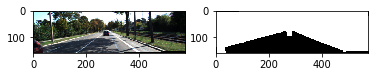

In [9]:
##Just to check.To check the batch functions. Do not run if not required
image_shape = (160, 576)
filenames_test = glob('data/data_road/training/gt_image_2/*road*')
get_batches_fn = gen_batch(
          filenames=filenames_test,
          image_shape=image_shape,
          augment=True)
images, labels =next(get_batches_fn(50, shuffle=False))
#a=labels[0][:,:,2]

#plt.imshow(labels[0],cmap='gray')
fig = plt.figure()
plt.subplot(121)
plt.imshow(images[49])
#print(np.amax(images[49]))

plt.subplot(122)
plt.imshow(labels[49][:,:,0],cmap='gray')

print(np.shape(images))
print(images.dtype)
print(np.shape(labels))
print(labels.dtype)

## Load VGG-16 model and build FCN

In [10]:
num_classes = 2

# Load saved model
vgg_tag = 'vgg16'

with tf.Session() as sess:
  tf.saved_model.loader.load(sess, [vgg_tag], vgg_path + 'vgg')

# Gather required tensor references
vgg_input_tensor_name = 'image_input:0'
vgg_keep_prob_tensor_name = 'keep_prob:0'
vgg_layer3_out_tensor_name = 'layer3_out:0'
vgg_layer4_out_tensor_name = 'layer4_out:0'
vgg_layer7_out_tensor_name = 'layer7_out:0'

graph = tf.get_default_graph()

input_image = graph.get_tensor_by_name(vgg_input_tensor_name)
keep_prob = graph.get_tensor_by_name(vgg_keep_prob_tensor_name)
vgg_layer3_out = graph.get_tensor_by_name(vgg_layer3_out_tensor_name)
vgg_layer4_out = graph.get_tensor_by_name(vgg_layer4_out_tensor_name)
vgg_layer7_out = graph.get_tensor_by_name(vgg_layer7_out_tensor_name)

# Regularizers and initializers
# initializer = lambda: tf.contrib.layers.xavier_initializer()
initializer = lambda: tf.truncated_normal_initializer(stddev=0.01)
regularizer = lambda: tf.contrib.layers.l2_regularizer(1e-5)

# 1x1 convolution
layer7_out = tf.layers.conv2d(
    inputs=vgg_layer7_out,
    filters=num_classes,
    kernel_size=1,
    padding='same',
    kernel_regularizer=regularizer(),
    kernel_initializer=initializer())

# Upsample
layer7_up = tf.layers.conv2d_transpose(
    inputs=layer7_out,
    filters=num_classes,
    kernel_size=4,
    strides=(2, 2),
    padding='same',
    kernel_regularizer=regularizer(),
    kernel_initializer=initializer())

# 1x1 convolution
layer4_out = tf.layers.conv2d(
    inputs=vgg_layer4_out,
    filters=num_classes,
    kernel_size=1,
    padding='same',
    kernel_regularizer=regularizer(),
    kernel_initializer=initializer())

# Skip layer
skip_1 = tf.add(layer7_up, layer4_out)

# Upsample
skip_1_up = tf.layers.conv2d_transpose(
    inputs=skip_1,
    filters=num_classes,
    kernel_size=4,
    strides=(2, 2),
    padding='same',
    kernel_regularizer=regularizer(),
    kernel_initializer=initializer())

# 1x1 convolution
layer3_out = tf.layers.conv2d(
    inputs=vgg_layer3_out,
    filters=num_classes,
    kernel_size=1,
    padding='same',
    kernel_regularizer=regularizer(),
    kernel_initializer=initializer())

# Skip layer
skip_2 = tf.add(skip_1_up, layer3_out)

# Upsampled final
nn_last_layer = tf.layers.conv2d_transpose(
    inputs=skip_2,
    filters=num_classes,
    kernel_size=16,
    strides=(8, 8),
    padding='same',
    kernel_regularizer=regularizer(),
    kernel_initializer=initializer())

INFO:tensorflow:Restoring parameters from b'models/vgg/variables/variables'


## Define training operations

In [11]:
correct_label = tf.placeholder(tf.int32, [None, None, None, num_classes])
learning_rate = tf.placeholder(tf.float32)
logits = tf.reshape(nn_last_layer, (-1, num_classes))
truth = tf.reshape(correct_label, (-1, num_classes))
global_step = tf.Variable(0, name='global_step', trainable=False)

# Cross-entropy operation
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=truth)
cross_entropy_loss = tf.reduce_mean(cross_entropy)
tf.summary.scalar('cross_entropy_loss', cross_entropy_loss)

# Regularization loss
l2_loss = tf.losses.get_regularization_loss()
tf.summary.scalar('l2_loss', l2_loss)
total_loss = cross_entropy_loss + l2_loss
tf.summary.scalar('total_loss', total_loss)
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(total_loss, global_step)

# Merge summary operation
merged = tf.summary.merge_all()

## Perform training if no saved model is available

In [14]:
# Hyperparameters
augment_training = True
batch_size = 8
epochs = 50
min_epochs = 20
patience = 3
random_seed = 1337
starting_learning_rate = 1e-4

# Training configuration
image_shape = (160, 576)
data_dir = './data'

saver = tf.train.Saver()

with tf.Session() as sess:
    writer = tf.summary.FileWriter('tensorboard')  # , sess.graph) Disable graph
    sess.run(tf.global_variables_initializer())
    # Path to vgg model
    vgg_path = os.path.join('models', 'vgg')

    # Prepare training and test datasets
    filenames = glob('data/data_road/training/gt_image_2/*road*')
    print('Dataset contains', len(filenames), 'examples.')
    np.random.seed(random_seed)  # Make it reproduceable
    np.random.shuffle(filenames)
    training = int(len(filenames) * .85)  # 85% for training, 15% for testing
    training, testing = filenames[:training], filenames[training:]

    # Check a saved model exists or train a new one
    try:
      # assert False  # Force training a new model
      assert os.path.exists('./model.ckpt.meta')
    except:
      # Train new model
      print('Training on', len(training), 'samples.')
      get_batches_fn = gen_batch(
          filenames=training,
          image_shape=image_shape,
          augment=augment_training)

      # Continue training while the loss improves
      best_loss = 1e9
      failure = 0
      for e in range(epochs):
        epoch_loss = 0
        num_images = 0
        sys.stdout.flush()
        for images, labels in tqdm(get_batches_fn(batch_size, shuffle=True),
                                   desc='Training epoch {}'.format(e + 1),
                                   total=ceil(len(training) / batch_size)):
            print(labels.dtype)
            summary, step, _, loss = sess.run([
              merged,
              global_step,
              train_op,
              cross_entropy_loss], feed_dict={
                  input_image: images,
                  correct_label: labels,
                  keep_prob: 0.5,
                  learning_rate: starting_learning_rate})
            writer.add_summary(summary, step)
            epoch_loss += loss * len(images)
            num_images += len(images)

        epoch_loss /= num_images
        sys.stderr.flush()
        print('Epoch {} loss: {:.3f}'.format(e + 1, epoch_loss))
        if e >= min_epochs and epoch_loss > best_loss:
          if failure == patience:
            break
          failure += 1
        else:
            failure = 0
            best_loss = epoch_loss
            print('Saving model')
            saver.save(sess, './model.ckpt')

Dataset contains 289 examples.
Training on 245 samples.


Training epoch 1:   0%|          | 0/31 [00:00<?, ?it/s]/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/anaconda/en

bool


Training epoch 1:   3%|▎         | 1/31 [01:16<38:22, 76.75s/it]

bool


Training epoch 1:   6%|▋         | 2/31 [02:42<38:24, 79.48s/it]

bool


Training epoch 1:  10%|▉         | 3/31 [04:05<37:37, 80.64s/it]

bool


Training epoch 1:  13%|█▎        | 4/31 [05:20<35:25, 78.72s/it]

bool


KeyboardInterrupt: 

## Evaluate model performance on test dataset

In [7]:
with tf.Session() as sess:
  # Reload the best model found
  print('Reloading best model')
  saver.restore(sess, './model.ckpt')

  # Evaluate
  print('Testing on {} samples.'.format(len(testing)))
  results, losses = [], []
  sys.stdout.flush()
  for images, labels in tqdm(gen_batch(testing, image_shape)(1),
                             desc='Evaluating testing dataset',
                             total=len(testing)):
    result, loss = sess.run([tf.nn.softmax(logits), cross_entropy_loss], feed_dict={
        input_image: images,
        correct_label: labels,
        keep_prob: 1.0})
    predic = (result[:, 1] > .5).reshape((-1, ))
    actual = (labels[:, :, :, 1] > .5).reshape((-1, ))
    
    inter = predic * actual  # Element-wise multiplication of 0 and 1
    union = np.zeros_like(predic)
    union[predic == 1] = 1
    union[actual == 1] = 1
    results.append([images, predic, actual, np.sum(inter) / np.sum(union)])
    losses.append(loss)

sys.stderr.flush()
results = sorted(results, key=lambda r: r[3], reverse=True)
print('Average IOU', np.average([r[3] for r in results]))
print('Testing loss:', np.average(losses))

Reloading best model
INFO:tensorflow:Restoring parameters from ./model.ckpt
Testing on 44 samples.


Evaluating testing dataset:   0%|          | 0/44 [00:00<?, ?it/s]/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
Ev

Average IOU 0.8537482905196655
Testing loss: 0.080883056


## Plot the best and worst

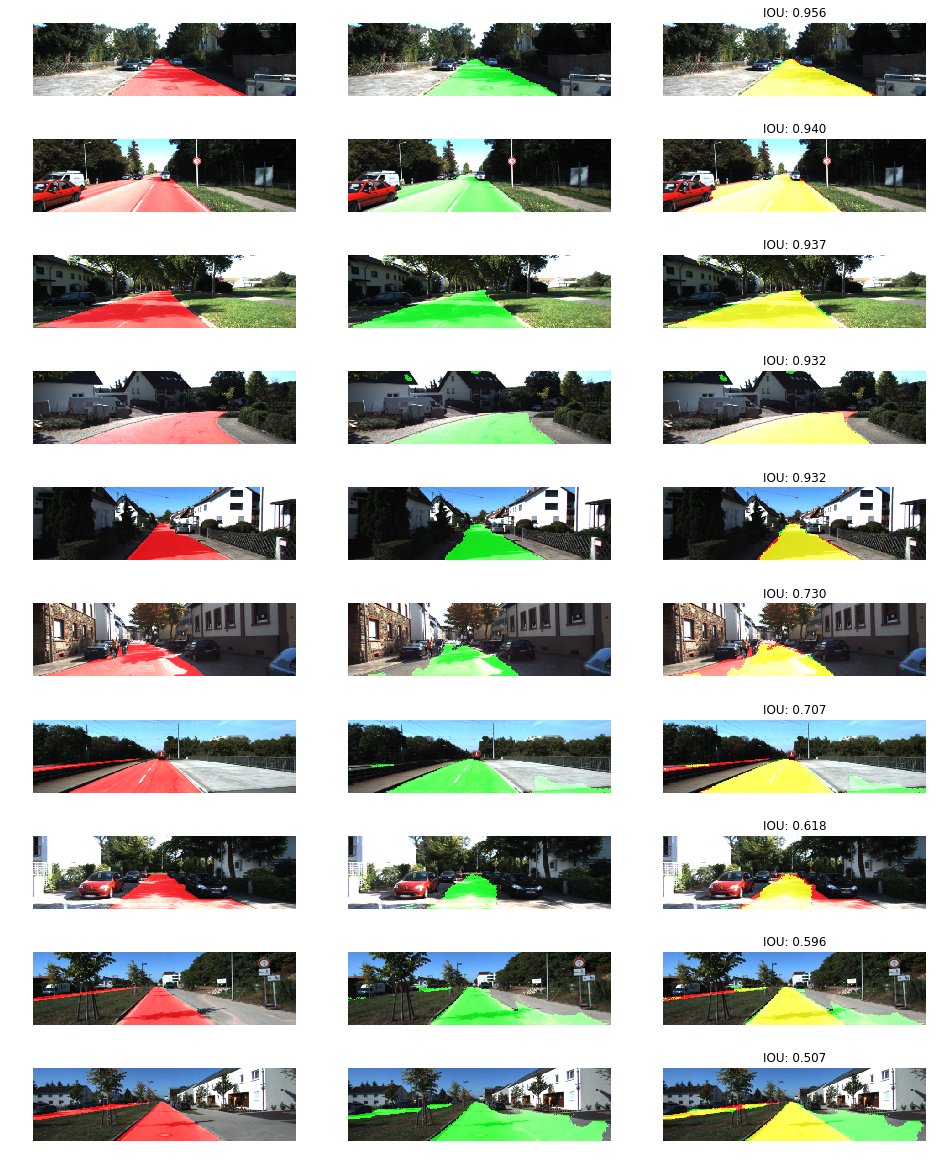

In [8]:
f, ax = plt.subplots(nrows=10, ncols=3)
f.set_size_inches(16, 21)
to_show = results[:5] + results[-5:]
for i, r in enumerate(to_show):
  # Generate red mask for ground truth
  a = np.dot(r[2].reshape(160, -1, 1), np.array([[PIXEL_MAX * .8, 0, 0]]))
  # Generate green mask for predictions
  b = np.dot(r[1].reshape(160, -1, 1), np.array([[0, PIXEL_MAX * .8, 0]]))
  # Apply masks
  p = r[0][0] + a
  p[p > PIXEL_MAX] = PIXEL_MAX
  q = r[0][0] + b
  q[q > PIXEL_MAX] = PIXEL_MAX
  # Yellow shows intersection
  s = r[0][0] + a + b
  s[s > PIXEL_MAX] = PIXEL_MAX
  ax[i, 0].imshow(p.astype(np.uint8))
  ax[i, 1].imshow(q.astype(np.uint8))
  ax[i, 2].imshow(s.astype(np.uint8))
  ax[i, 2].set_title('IOU: {:.3f}'.format(r[3]))

 
  for j in range(3):
    ax[i, j].axis('off')
plt.show()

## Legacy code

The code below was experimented but didn't show good results.

The first snippet relates to using a separate validation dataset. Decided against using a validation dataset as both training and validation losses moved along the same lines and this frees a few more examples for training in this limited dataset.

The second one implements a polynomially decaying learning rate, which didn't yield better results than a stable 1e-4.

In [10]:
'''
# Validation dataset generation and usage
valid = int(len(filenames) * .85)
print('Validating on', len(valid), 'samples.')
training, valid, testing = filenames[:training], filenames[training:valid], filenames[valid:]
valid_loss = 0
valid_images = 0
for images, labels in gen_batch(valid, image_shape)(batch_size):
  valid_loss += sess.run(cross_entropy_loss, feed_dict={
      input_image: images,
      correct_label: labels,
      keep_prob: 1.}) * len(images)
  valid_images += len(images)
valid_loss /= valid_images
print('Epoch {} validation loss: {:.3f}'.format(e + 1, valid_loss))

# Exponential decaying learning rate
min_lr = 5e-5
edlr = tf.train.exponential_decay(
    learning_rate=learning_rate,
    global_step=global_step,
    decay_steps=1,
    decay_rate=0.99)
edlr = tf.maximum(edlr, min_lr)  # Prevent underflow and updates getting too small
# edlr = learning_rate  # Disable exponential decay
tf.summary.scalar('learning_rate', edlr)
'''

"\n\nvalid = int(len(filenames) * .85)\nprint('Validating on', len(valid), 'samples.')\ntraining, valid, testing = filenames[:training], filenames[training:valid], filenames[valid:]\nvalid_loss = 0\nvalid_images = 0\nfor images, labels in gen_batch(valid, image_shape)(batch_size):\n  valid_loss += sess.run(cross_entropy_loss, feed_dict={\n      input_image: images,\n      correct_label: labels,\n      keep_prob: 1.}) * len(images)\n  valid_images += len(images)\nvalid_loss /= valid_images\nprint('Epoch {} validation loss: {:.3f}'.format(e + 1, valid_loss))\n\n# Exponential decaying learning rate\nmin_lr = 5e-5\nedlr = tf.train.exponential_decay(\n    learning_rate=learning_rate,\n    global_step=global_step,\n    decay_steps=1,\n    decay_rate=0.99)\nedlr = tf.maximum(edlr, min_lr)  # Prevent underflow and updates getting too small\n# edlr = learning_rate  # Disable exponential decay\ntf.summary.scalar('learning_rate', edlr)\n"